https://coderzcolumn.com/tutorials/machine-learning/shap-explain-machine-learning-model-predictions-using-game-theoretic-approach

In [75]:
import pandas as pd
import numpy as np
import shap
shap.initjs()

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression



In [12]:
from sklearn.datasets import fetch_california_housing

# from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay

X, y = fetch_california_housing(return_X_y=True, as_frame=True)

In [68]:
housing=fetch_california_housing()
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [14]:
X.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25

In [17]:
X.shape

(20640, 8)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.85, test_size=0.15, random_state=123, shuffle=True)

print("Train/Test Sizes : ",X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

print()
print("Test  R^2 Score : ", lin_reg.score(X_test, Y_test))
print("Train R^2 Score : ", lin_reg.score(X_train, Y_train))

Train/Test Sizes :  (17544, 8) (3096, 8) (17544,) (3096,)

Test  R^2 Score :  0.6161261171507484
Train R^2 Score :  0.6043605288558029


We'll start by creating LinearExplainer which is commonly used for the linear model. It has the below-mentioned arguments:

- model - It accepts the model which we trained with train data. It can even accept tuple of (coef, intercept) instead.
- data - It accepts data based on which it'll generate SHAP values. We can provide a numpy array, pandas dataframe, scipy sparse matrix, etc. It can also accept tuple with (mean, cov).
- feature_perturbation - It accepts one of the below strings.
    - interventional - It lets us compute SHAP values discarding the relationship between features.
    - correlation_dependent - It lets us compute SHAP values considering relationship between features.
- nsamples - It accepts integer specifying a number of samples to use for calculating transformation matrix used to account for feature correlation when feature_perturbation is set to correlation_dependent.

In [93]:
lin_reg_explainer1 = shap.LinearExplainer(lin_reg, X_train)

Below we have used explainer to generate shape value for the 0th sample from the test dataset using the shap_values() method of explainer. The explainer object has a base value to which it adds shape values for a particular sample in order to generate a final prediction. The base value is stored in the expected_value attribute of the explainer object. All model predictions will be generated by adding shap values generated for a particular sample to this expected value. Below we have printed the base value and then generated prediction by adding shape values to this base value in order to compare prediction with the one generated by linear regression.



In [94]:
sample_idx = 0

shap_vals = lin_reg_explainer1.shap_values(X_test.iloc[0])

print("Expected/Base Value : ", lin_reg_explainer1.expected_value)
print()
print("Shap Values for Sample %d : "%sample_idx, shap_vals)
print("\n")
print("Prediction From Model                            : ", lin_reg.predict(X_test.iloc[sample_idx].values.reshape(1,-1)))
print("Prediction From Adding SHAP Values to Base Value : ", lin_reg_explainer1.expected_value + shap_vals.sum())


Expected/Base Value :  2.1022418835665846

Shap Values for Sample 0 :  [-4.14266339e-02  1.12611795e-01  4.05291748e-02 -3.40096395e-02
  3.07518280e-03  1.26731857e-03 -1.08119832e+00  1.27523258e+00]


Prediction From Model                            :  [2.37832333]
Prediction From Adding SHAP Values to Base Value :  2.3783233345852532


X does not have valid feature names, but LinearRegression was fitted with feature names


Below we have created another LinearExplainer by giving model and train data as input. We have also set feature_perturbation to correlation_dependent. This will create an explainer which takes into account the relationship between features.

In [95]:
lin_reg_explainer2 = shap.LinearExplainer(lin_reg, X_train, feature_perturbation="correlation_dependent")

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

In [66]:
sample_idx = 0

shap_vals = lin_reg_explainer2.shap_values(X_test.iloc[sample_idx].values.reshape(1,-1))

print("Base Value : ", lin_reg_explainer2.expected_value)
print()
print("Shap Values for Sample %d : "%sample_idx, shap_vals)
print("\n")
print("Prediction From Model                            : ", lin_reg.predict(X_test.iloc[sample_idx].values.reshape(1,-1)))
print("Prediction From Adding SHAP Values to Base Value : ", lin_reg_explainer2.expected_value + shap_vals.sum())

Base Value :  2.0649043000455976

Shap Values for Sample 0 :  [[ 0.02375844  0.10555696 -0.0129947   0.00412798  0.00429663  0.00150007
  -0.00887196  0.19604562]]


Prediction From Model                            :  [2.37832333]
Prediction From Adding SHAP Values to Base Value :  2.3783233345852506


X does not have valid feature names, but LinearRegression was fitted with feature names


### Bar Plot
The bar plot shows the shap values of each feature for a particular sample of data. Below is a list of important parameters of the bar_plot() method of shap.

shap_values - It accepts an array of shap values for an individual sample of data.
feature_names - It accepts a list of feature names.
max_display - It accepts integer specifying how many features to display in a bar chart.

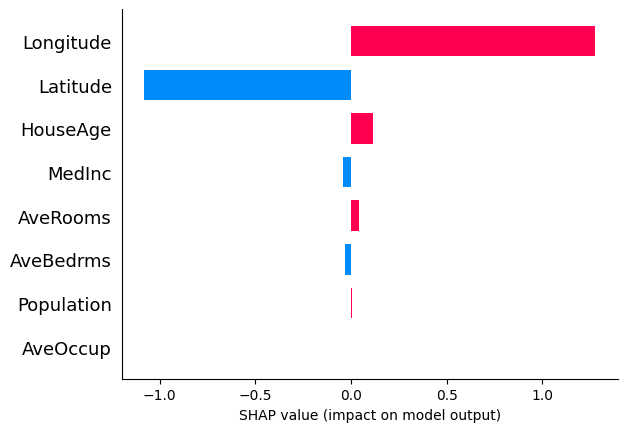

In [70]:
shap.bar_plot(lin_reg_explainer1.shap_values(X_test.iloc[0]),
              feature_names=housing.feature_names,
              max_display=len(housing.feature_names))

In [92]:
X_test.iloc[0].values.reshape(1,-1)[0]

array([ 3.79170000e+00,  4.00000000e+01,  4.95979899e+00,  1.03015075e+00,
        1.03900000e+03,  2.61055276e+00,  3.82400000e+01, -1.22640000e+02])

Below we have generated another bar plot of shap values for our second explainer which was based on the relationship between features.

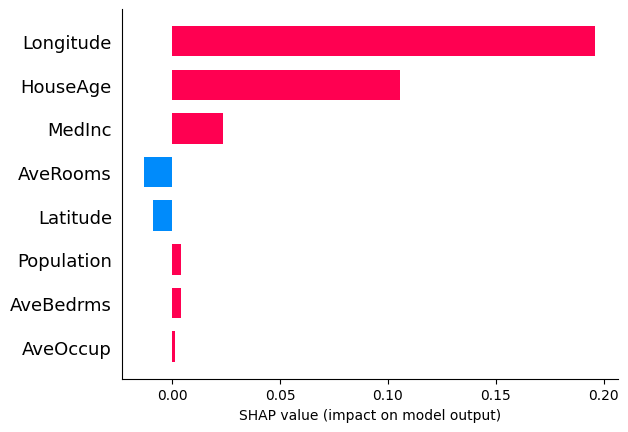

In [87]:
shap.bar_plot(lin_reg_explainer2.shap_values(X_test.iloc[0].values.reshape(1,-1))[0],
              feature_names=housing.feature_names,
              max_display=len(housing.feature_names))

We can see from the above bar chart that for this sample of data features (Longitude, HouseAGE,Medlnc,population,AveBedrms,AveOccup) contribute positively and features (AveRooms,Latitude) contributes positively for final prediction.

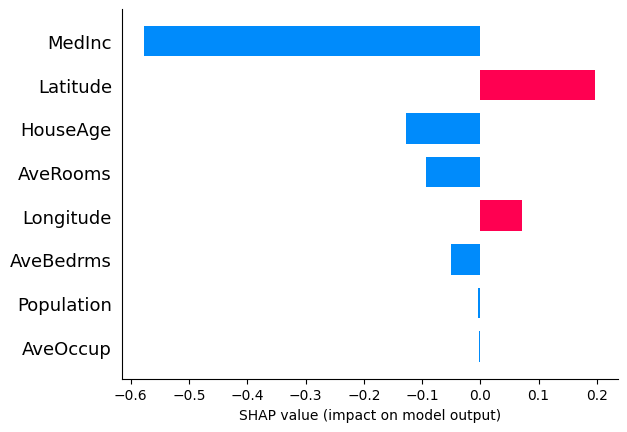

In [96]:
shap.bar_plot(lin_reg_explainer2.shap_values(X_test.iloc[6].values.reshape(1,-1))[0],
              feature_names=housing.feature_names,
              max_display=len(housing.feature_names))

### Waterfall Plot
The second chart that we'll explain is a waterfall chart which shows how shap values of individual features are added to the base value in order to generate a final prediction. Below is a list of important parameters of the waterfall_plot() method.

- shap_values - It accepts shap values object for an individual sample of data.
- max_display -It accepts integer specifying how many features to display in a bar chart.

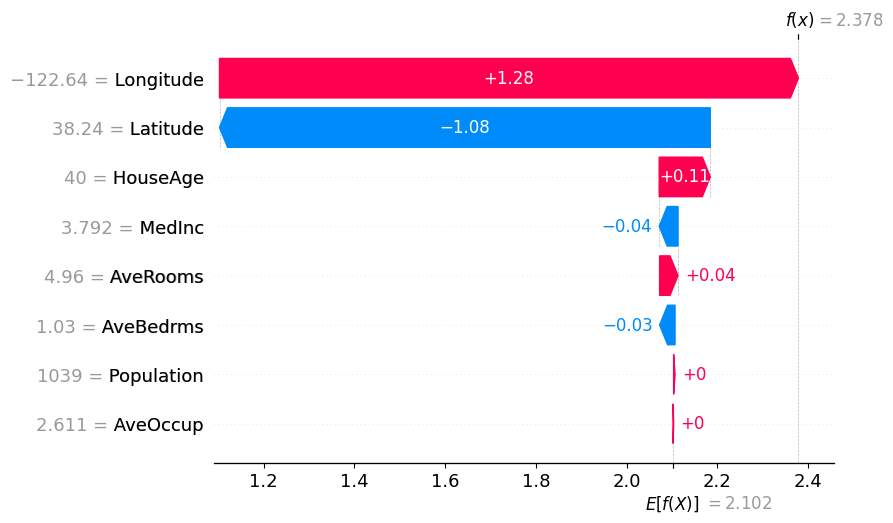

In [99]:
shap_values = lin_reg_explainer1(X_test[:1])
shap_values.feature_names = housing.feature_names

shap.waterfall_plot(shap_values[0], max_display=len(housing.feature_names))

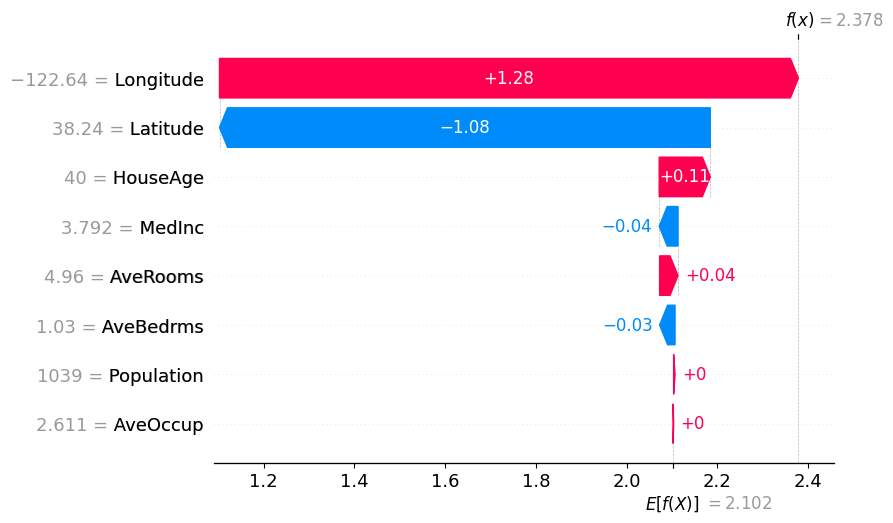

In [100]:
shap_values = lin_reg_explainer1(X_test)
shap_values.feature_names = housing.feature_names

shap.waterfall_plot(shap_values[0], max_display=len(housing.feature_names))

Below is the waterfall plot using the explainer2 in which relationship between features was considered.
 We can notice in shap values generated by both explainers as one considers relationship and one does not.

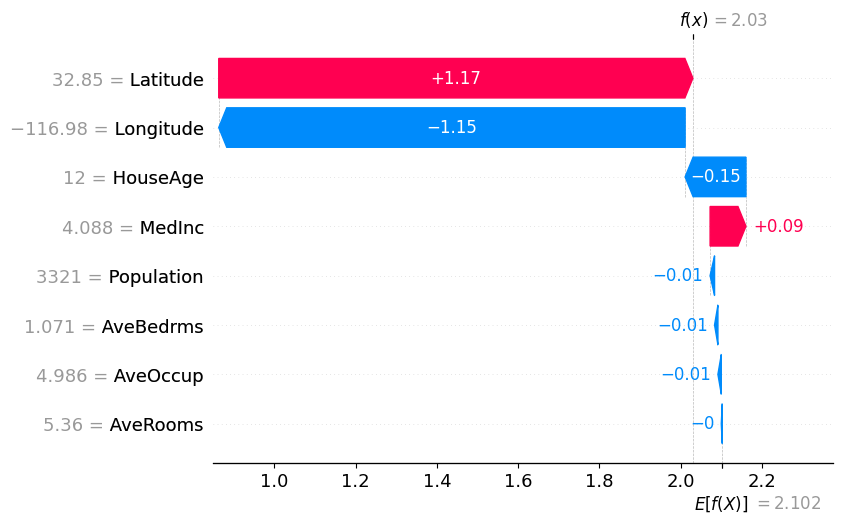

In [101]:
shap.waterfall_plot(shap_values[2], max_display=len(housing.feature_names))

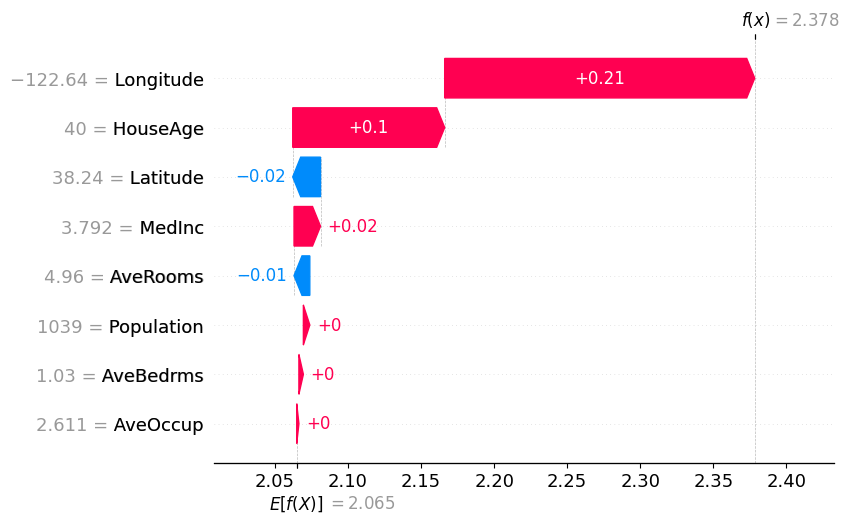

In [103]:
shap_values = lin_reg_explainer2(X_test)
shap_values.feature_names = housing.feature_names

shap.waterfall_plot(shap_values[0], max_display=len(housing.feature_names))

### __Decision Plot__
The decision plot shows like the waterfall chart show the decision path followed by applying the shap values of individual features one by one to the expected value in order to generate predicted value as a line chart.

The decision plot can be used to show a decision path followed for more than one sample as well. Below is a list of important parameters of the decision_plot() method.

- expected_value - It accepts base value on which shap values will be added. The explainer object has a property named expected_value which needs to be passed to this parameter.
- shap_values - It accepts an array of shap values for an individual sample of data.
- feature_names - It accepts a list of feature names.
- feature_order - It accepts a list of below values as input and orders feature accordingly.
    - importance - Default Value. Orders feature according to the importance
    - hcluse - Hierarchical Clustering
    - none
    - list of array of indices
- highlight - It accepts a list of indexes specifying which samples to highlight from the list of samples.
- link - It accepts string specifying type of transformation used for the x-axis. It accepts one of the below values.
    - identity
    - logit
- plot_color - It accepts matplotlib colormap to use to the color plot.
- color_bar - It accepts boolean value specifying whether to display color bar or not.

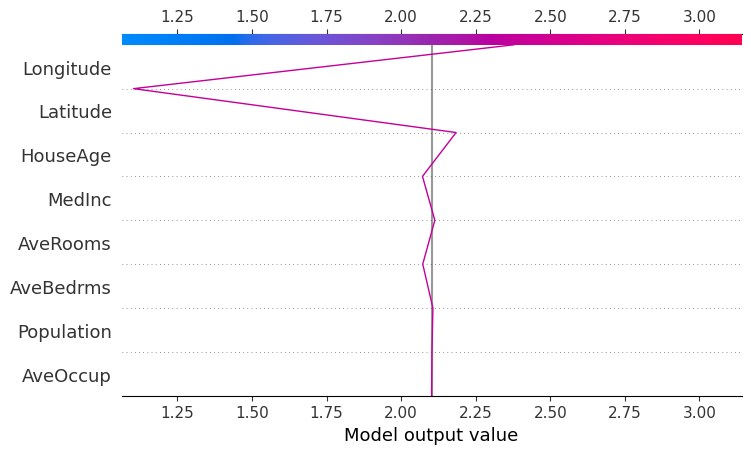

In [114]:
shap.decision_plot(lin_reg_explainer1.expected_value,lin_reg_explainer1.shap_values(X_test.iloc[0]),feature_names=housing.feature_names)

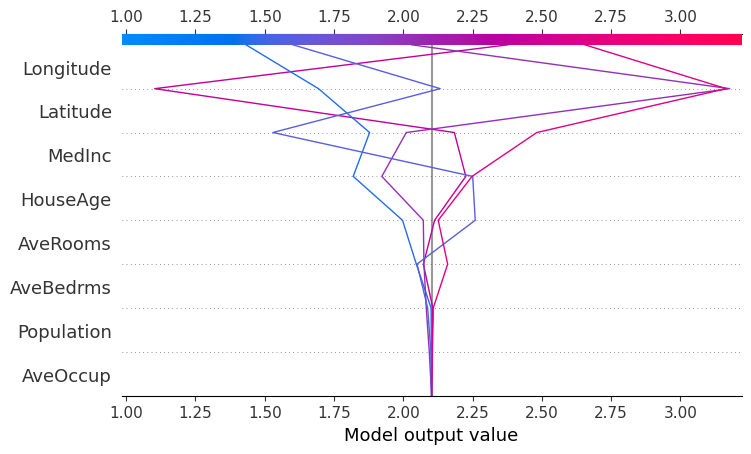

In [115]:
shap.decision_plot(lin_reg_explainer1.expected_value,lin_reg_explainer1.shap_values(X_test.iloc[0:5]),feature_names=housing.feature_names)

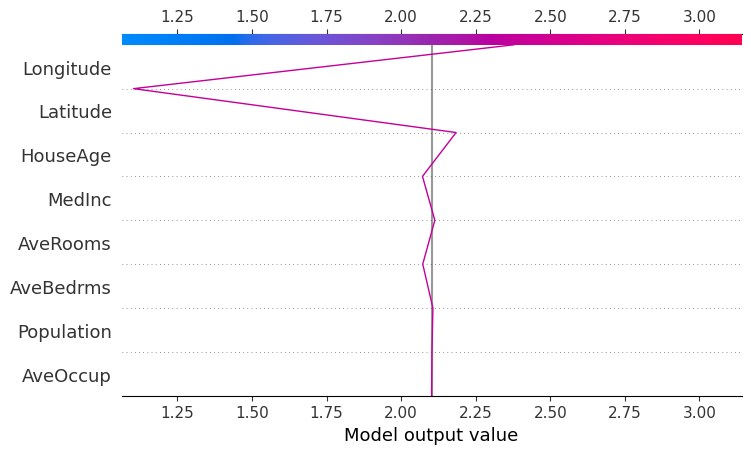

In [117]:
shap.decision_plot(lin_reg_explainer1.expected_value,lin_reg_explainer1.shap_values(X_test.iloc[0]),feature_names=housing.feature_names)

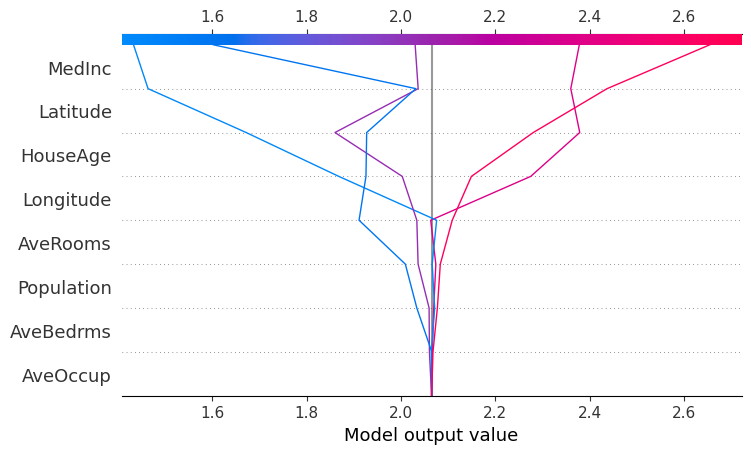

In [116]:
shap.decision_plot(lin_reg_explainer2.expected_value,lin_reg_explainer2.shap_values(X_test.iloc[0:5]),feature_names=housing.feature_names)

### Dependence Plot
The dependence plot shows the relation between actual feature value and shap values for a particular feature of the dataset. We can generate a dependence plot using the dependence_plot() method. Below is a list of important parameters of the dependence_plot() method.

SHAP dependence plots show the effect of a single (or two) feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature can be chosen for coloring to highlight possible interactions.

We can use the dependence_plot method for ploting the effect of a feature on the prediction with or without the influence of another feature. If you don't give any interaction_index parameter, SHAP will decide by itself and propose automatically an interaction feature for you.

- ind - It accepts either integer specifying the index of feature from data or string specifying the name of the feature. For future names given as a string, we need to provide feature names as a list to parameter feature_names.
- shap_values - It accepts an array of shap values for an individual sample of data.
- features - It accepts dataset which was used to generate shap values given to the shap_values parameter.
- feature_names - It accepts a list of feature names.

__Dependence plot with interaction__

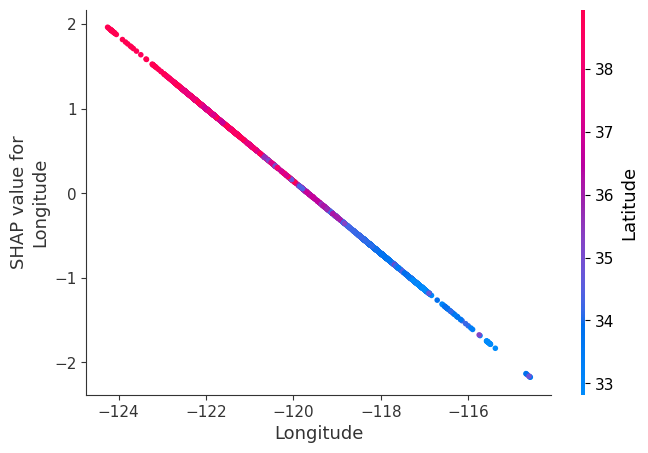

In [136]:
shap.dependence_plot("Longitude",
                     lin_reg_explainer1.shap_values(X_test),interaction_index="Latitude",
                     features=X_test,
                     feature_names=housing.feature_names,
                     )

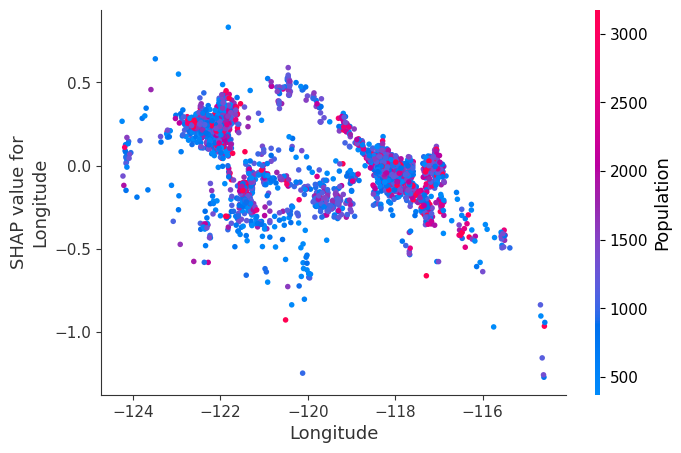

In [143]:
shap.dependence_plot("Longitude",
                     lin_reg_explainer2.shap_values(X_test),interaction_index="Population",
                     features=X_test,
                     feature_names=housing.feature_names,
                     )

__Below is the dependence plot without interaction value, interaction index is chosen automatically by shap__

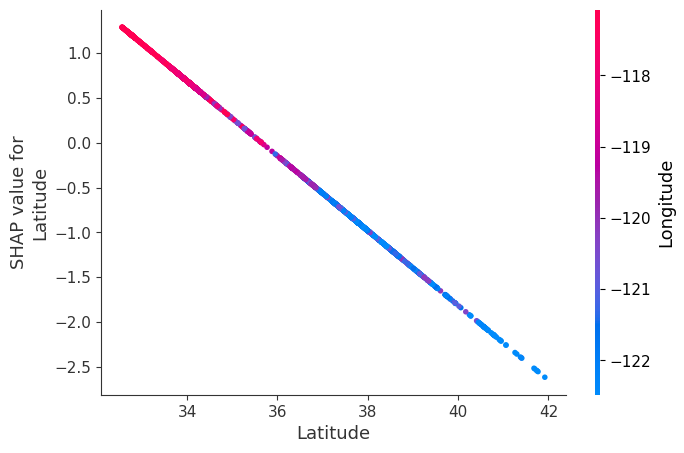

In [138]:
shap.dependence_plot("Latitude", 
                     lin_reg_explainer1.shap_values(X_test),features=X_test,feature_names=housing.feature_names,)

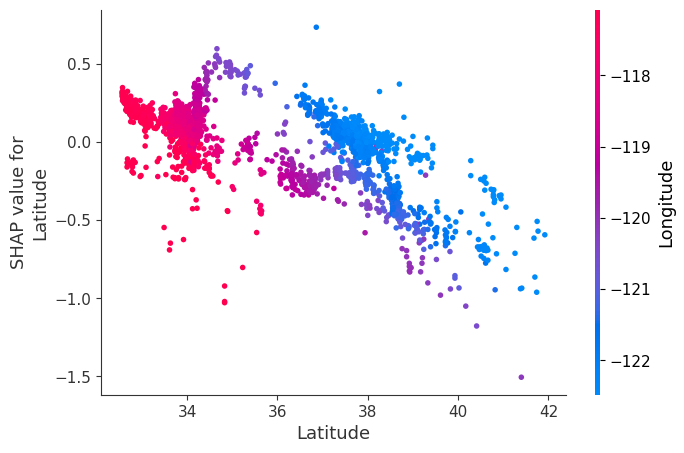

In [140]:
shap.dependence_plot("Latitude", 
                     lin_reg_explainer2.shap_values(X_test),features=X_test,feature_names=housing.feature_names,)

### Force Plot
The force plot shows shap values contributions in generating final prediction using an additive force layout. It shows which features contributed to how much positively or negatively to base value to generate a prediction.

We can generate force plot using force_plot() method. Below are list of important parameters for force_plot() method.

- expected_value - It accepts base value on which shap values will be added. The explainer object has a property named expected_value which needs to be passed to this parameter.
- shap_values - It accepts an array of shap values for an individual sample of data.
- feature_names - It accepts a list of feature names.
- out_names - It accepts string specifying target variable name.

__Below are the forceplots using explainer1 and explainer2__

In [150]:
shap.force_plot(lin_reg_explainer1.expected_value,lin_reg_explainer1.shap_values(X_test.iloc[0]),out_names="price",feature_names=housing.feature_names,
              )

In [152]:
shap.force_plot(lin_reg_explainer2.expected_value,lin_reg_explainer1.shap_values(X_test.iloc[4]),out_names="price",feature_names=housing.feature_names
             
              )

__Below is the forceplot for first 10 samples from the test dataset__
- x axis values are samples.
- y axis values are the predicted outputs for the samples

In [153]:
shap.force_plot(lin_reg_explainer1.expected_value,
                lin_reg_explainer1.shap_values(X_test[0:10]),
                feature_names=housing.feature_names,
                out_names="Price($)", figsize=(25,3),
                link="identity")

### Summary Plot
The summary plot shows the beeswarm plot showing shap values distribution for all features of data. We can also show the relationship between the shap values and the original values of all features.

We can generate summary plot using summary_plot() method. Below are list of important parameters of summary_plot() method.

- shap_values - It accepts array of shap values for individual sample of data.
- features - It accepts dataset which was used to generate shap values given to shap_values parameter.
- feature_names - It accepts list of feature names.
- max_display -It accepts integer specifying how many features to display in bar chart.
- plot_type - It accepts one of the below strings as input.
    - dot (default for single output)
    - bar - (default for multiple output)
    - violin
    
Below we have generated a summary plot of shap values generated from the test dataset using the first linear explainer. We can see a distribution of shap values and their relation with actual feature values based on the color bar on the right side.

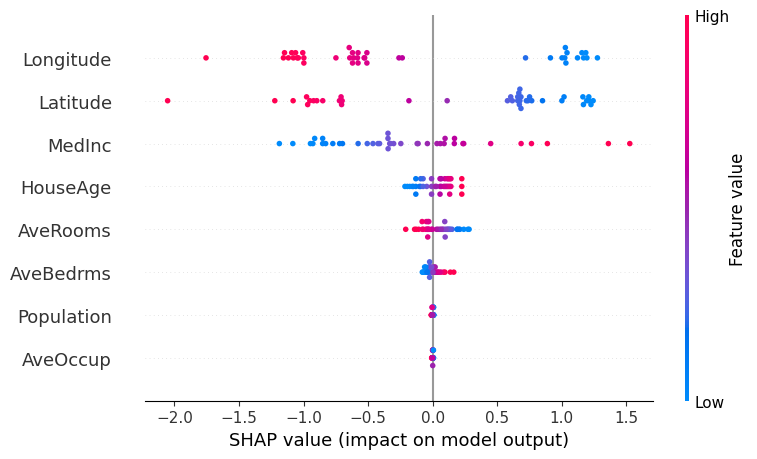

In [160]:
shap.summary_plot(lin_reg_explainer1.shap_values(X_test.iloc[0:40]),
                  features = X_test.iloc[0:40],
                  feature_names=housing.feature_names)

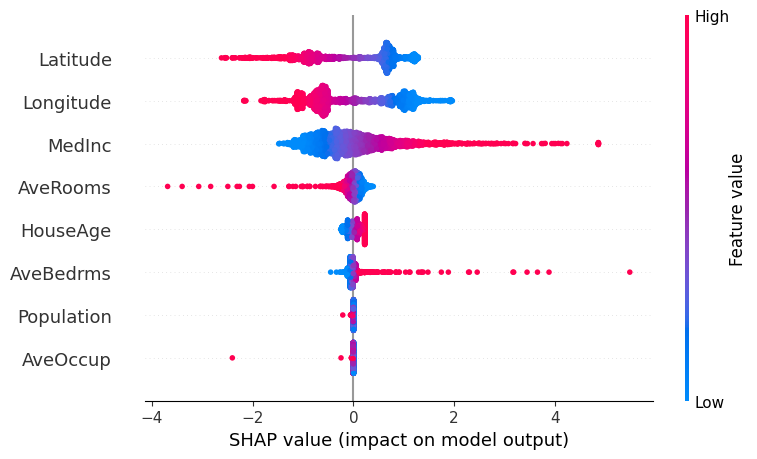

In [162]:
shap.summary_plot(lin_reg_explainer1.shap_values(X_test),
                  features = X_test,
                  feature_names=housing.feature_names)

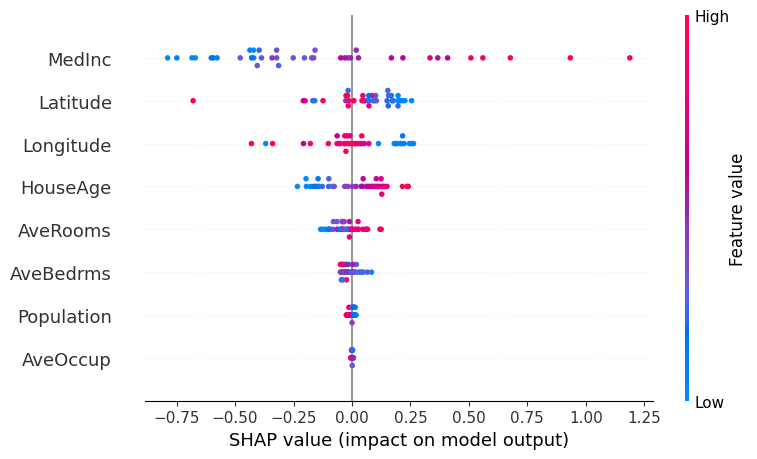

In [164]:
shap.summary_plot(lin_reg_explainer2.shap_values(X_test.iloc[0:40]),
                  features = X_test.iloc[0:40],
                  feature_names=housing.feature_names)

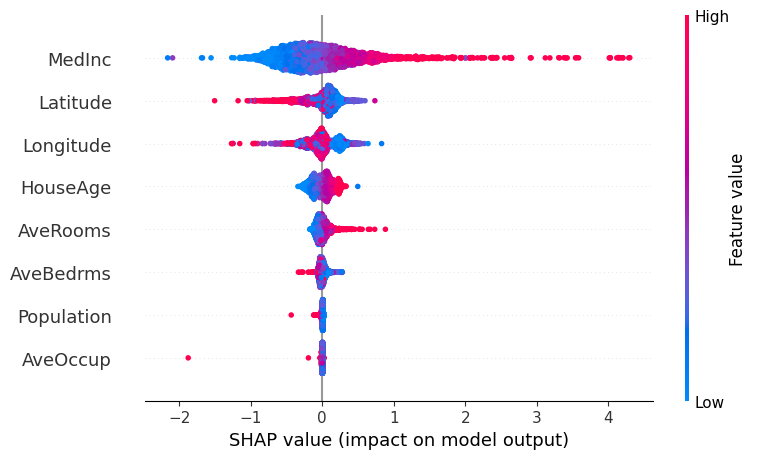

In [163]:
shap.summary_plot(lin_reg_explainer2.shap_values(X_test),
                  features = X_test,
                  feature_names=housing.feature_names)

Below we have generated a summary plot with plot type as bar based on shape values generated from test data using the first linear explainer. The bar chart shows the average impact of each feature on the final prediction. This also highlights feature importance based on shap values.

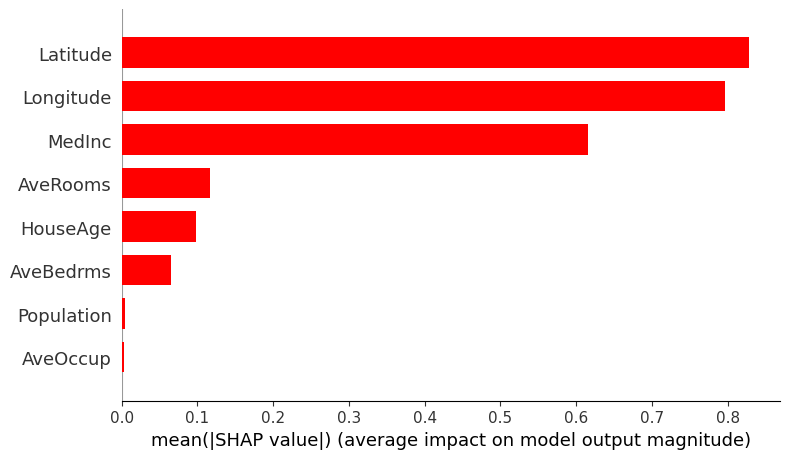

In [170]:
shap.summary_plot(lin_reg_explainer1.shap_values(X_test),
                  features = X_test,plot_type='bar',
                  color="red",
                  feature_names=housing.feature_names)

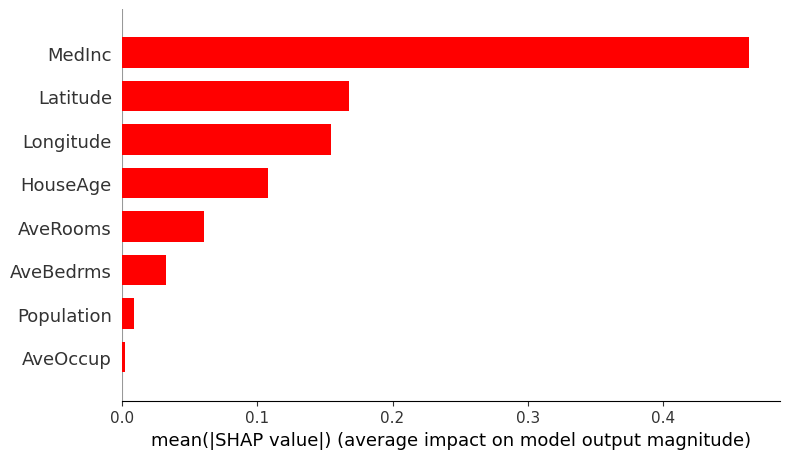

In [169]:
shap.summary_plot(lin_reg_explainer2.shap_values(X_test),
                  features = X_test,plot_type='bar',
                  color="red",
                  feature_names=housing.feature_names)

Below we have generated a summary plot with plot type as violin based on shape values generated from test data using the first linear explainer.

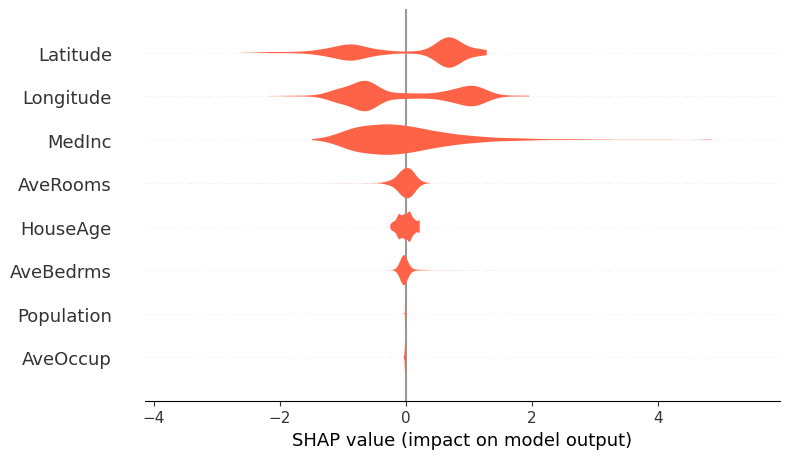

In [172]:
shap.summary_plot(lin_reg_explainer1.shap_values(X_test),
                  feature_names=housing.feature_names,
                  plot_type="violin",
                  color="tomato")

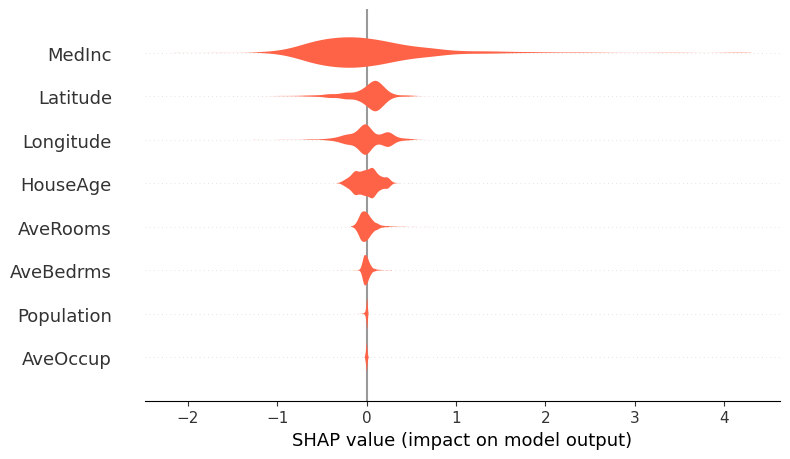

In [174]:
shap.summary_plot(lin_reg_explainer2.shap_values(X_test),
                  feature_names=housing.feature_names,
                  plot_type="violin",
                  color="tomato")

### Partial Dependence Plot
The shap also provides us with a method named partial_dependence_plot() which can be used to generate a partial dependence plot. Below are list of important parameters of partial_dependence_plot() method.

- ind - It accepts either integer specifying the index of feature from data or string specifying the name of the feature. For future names given as a string, we need to provide feature names as a list to parameter feature_names.
- model - It expects a method that predicts the output of the model.
- data - It's data that will be used for generating the plot.
- feature_names - It accepts a list of feature names.

Below we have generated a partial dependence plot of the LSTAT feature based on test data.

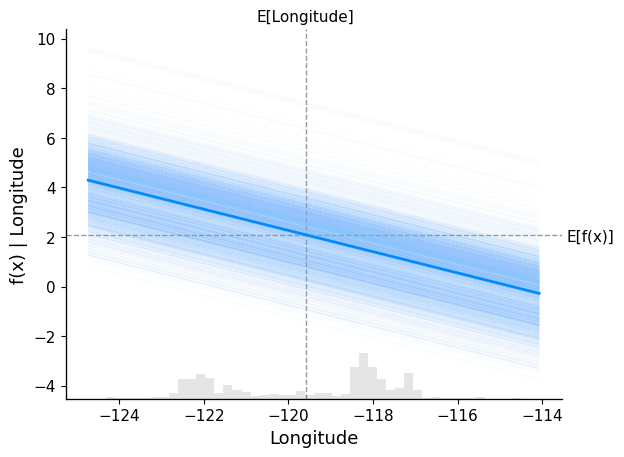

In [176]:
shap.partial_dependence_plot("Longitude",
                             lin_reg.predict,
                             data=X_test,
                             feature_names=housing.feature_names,
                             model_expected_value=True,
                             feature_expected_value=True,
                             ice=True)

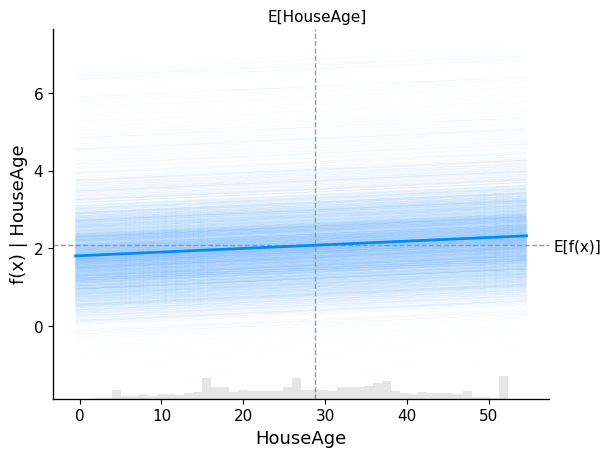

In [177]:
shap.partial_dependence_plot("HouseAge",
                             lin_reg.predict,
                             data=X_test,
                             feature_names=housing.feature_names,
                             model_expected_value=True,
                             feature_expected_value=True,
                             ice=True)

### Embedding Plot
The embedding plot projects shap values to 2D projection using PCA for visualization. This can help us see the spread of different shap values for a particular feature.

We can generate an embedding plot using the embedding_plot() method. Below is a list of important parameters of the embedding_plot() method.

- ind - It accepts either integer specifying the index of feature from data or string specifying the name of the feature. For future names given as a string, we need to provide feature names as a list to parameter feature_names.
- shap_values - It accepts an array of shap values for an individual sample of data.
- feature_names - It accepts a list of feature names.
- method - It accepts string pca or numpy array as input. If pca is given then use PCA to generate 2D projection. If a numpy array is given then its size should be (no_of_sample x 2) and will be considered embedding values.

Below we have generated an embedding plot for the CRIM feature on test data using our first linear explainer.

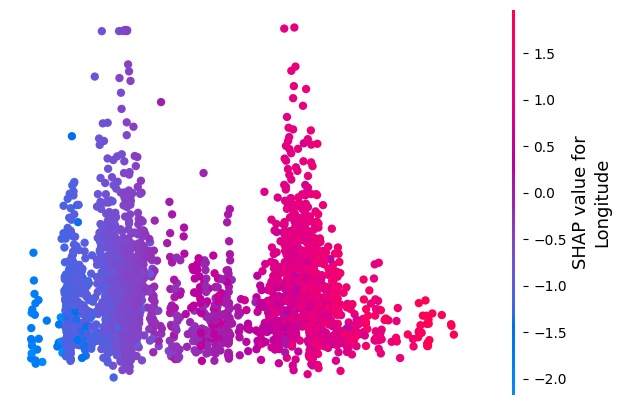

In [179]:
shap.embedding_plot("Longitude",
                    lin_reg_explainer1.shap_values(X_test),
                    feature_names=housing.feature_names)

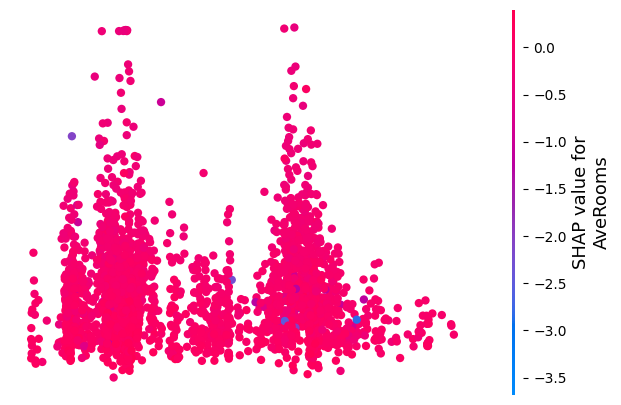

In [180]:
shap.embedding_plot("AveRooms",
                    lin_reg_explainer1.shap_values(X_test),
                    feature_names=housing.feature_names)